# Extended Kalman Filter Design

The objective here is to estimate the state $x$ from noisy sensors measurements $y$.

## Control model

Let's start by defining the discrete-time state-space model $x_{t+1} = f(x_t, u_t)$ where the state $x_t$ is a vector representing the pose of the robot (2D position and orientation), i.e. $x_t =  \begin{bmatrix} x_t\\ y_t\\\theta_t  \end{bmatrix}$, and $u_t$ denotes the control input (here the reading from a proprioceptive sensor). Hence, $u_t$ can be written as $u_t =  \begin{bmatrix} \Delta_{s_r}\\ \Delta_{s_l}  \end{bmatrix}$, where $\Delta_{s_r}$ and $\Delta_{s_l}$ are the encoder readings of the right and left wheel.

Furthermore, let's define some useful variables

\begin{itemize}
    \item $\Delta_{s_r}$ : travelled distance for the right wheel 
    \item $\Delta_{s_l}$ : travelled distance for the left wheel 
    \item $\Delta s = \frac{\Delta_{s_r} + \Delta_{s_l}}{2}$
    \item $(\Delta x, \Delta y, \Delta \theta)$ : path travelled in the last sampling interval of fixed length $T_s$
    \item $\Delta \theta = \frac{\Delta_{s_r} - \Delta_{s_l}}{b}$ 
    \item $b$ : the distance between the two wheels of the differential drive robot 
\end{itemize}
$x_{t+1}= f(x_t, u_t) = f(x_t, y_t, \theta_t, \Delta_{s_r}, \Delta_{s_l}) =  \begin{bmatrix} x_{t+1}\\ y_{t+1}\\\theta_{t+1}  \end{bmatrix} = \begin{bmatrix} x_t + \Delta_s cos(\theta_t + \frac{\Delta \theta}{2})\\ y_t + \Delta_s sin(\theta_t + \frac{\Delta \theta}{2}) \\ \theta_t + \Delta \theta  \end{bmatrix}$
 

Since $f(x_t, u_t)$ is a non-linear function, we will have to linearize it around tehe point ($\mu_{x_t}$,$\mu_{u_t}$). In order to do so, let's calculate the two jacobian matrices:

$F_x = \left.\frac{\partial f(x_t, u_t)}{\partial x_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
1 & 0 & -\Delta_s sin(\theta_t + \frac{\Delta \theta}{2}) \\ 
0 & 1 & \Delta_s cos(\theta_t + \frac{\Delta \theta}{2})\\ 
0 & 0 & 1
\end{bmatrix}$

$F_u = \left.\frac{\partial f(x_t, u_t)}{\partial u_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
\frac{1}{2} cos(\theta_t + \frac{\Delta \theta}{2}) - \frac{\Delta_s}{2b} sin(\theta_t + \frac{\Delta \theta}{2}) & \frac{1}{2} cos(\theta_t + \frac{\Delta \theta}{2}) + \frac{\Delta_s}{2b} sin(\theta_t + \frac{\Delta \theta}{2}) \\ 
\frac{1}{2} sin(\theta_t + \frac{\Delta \theta}{2}) + \frac{\Delta_s}{2b} cos(\theta_t + \frac{\Delta \theta}{2}) & \frac{1}{2} sin(\theta_t + \frac{\Delta \theta}{2}) - \frac{\Delta_s}{2b} cos(\theta_t + \frac{\Delta \theta}{2}) \\
\frac{1}{b} & - \frac{1}{b}
\end{bmatrix}$



The control input has an associated covariance matrix $R= \begin{bmatrix} k_r  |\Delta_{s_r}| & 0\\ 0 & k_l|\Delta_{s_l}|  \end{bmatrix}$, where $k_r$ and $k_r$ are constants to be determined experimentally. 


The prediction step is:
\begin{itemize}
    \item $\overline{\mu}_{t} = f(\mu_{x_{t-1}},\mu_{u_{t-1}})$
    \item $\overline{\Sigma}_{t} = F_x \Sigma_{t-1} F_x^T + F_u R F_u^T$
\end{itemize}

## Measurement model

The measurement model is the following :

$y_t = H_t x_t + \epsilon_t = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_t\\ y_t\\\theta_t  \end{bmatrix} + \epsilon_t$, where $\epsilon_t$ is the measurment noise with zero mean and covariance $Q = \begin{bmatrix} q_x & 0 & 0\\ 0 & q_y & 0 \\ 0 & 0 & q_{\theta}  \end{bmatrix} $. 

$z_t = \begin{bmatrix} z_{x_t}\\ z_{y_t}\\ z_{\theta_t}  \end{bmatrix}$ is the reading from the camera (exteroceptive sensor), also called the observation.

The kalman gain is defined as $K_t = \overline{\Sigma}_{t}H_t^T(H_t \overline{\Sigma}_{t} H_t^T + Q)^{-1} = \overline{\Sigma}_{t}( \overline{\Sigma}_{t} + Q)^{-1}$. 

Hence, the update step is :
\begin{itemize}
    \item $\mu_{t} = \overline{\mu}_{t} + K_t(z_t - \overline{\mu}_{t})$
    \item $\Sigma_{t} = (I-K_tH_t) \overline{\Sigma}_{t} = (I-K_t) \overline{\Sigma}_{t}$
\end{itemize}




In [432]:
import os
import sys
import time
import serial
import numpy as np
import math
import matplotlib.pyplot as plt

from tqdm import tqdm

Ts = 0.1

# tune model params 
qx = 0.2
qy = 0.2
qt = 0.4
k_delta_sr = 0.8
k_delta_sl = 0.8


b = 0.095
H = np.array([[1, 0, 0], [0, 1, 0],[0, 0, 1]])
stripe_width = 50
Q = np.array([[qx, 0, 0], [0, qy, 0], [0, 0, qt]]);
R = np.array([[k_delta_sr, 0], [0, k_delta_sl]]);

In [433]:
def jacobianF_x(theta, delta_s, delta_theta):
    
    Fx = np.array([[1, 0, -delta_s*np.sin(theta + delta_theta/2)], [0, 1, delta_s*np.cos(theta + delta_theta/2)], [0, 0, 1]])
    return Fx

def jacobianF_u(theta, delta_s, delta_theta):

    Fu = np.array([[1/2*np.cos(theta + delta_theta/2) - delta_s/(2*b)*np.sin(theta + delta_theta/2), 1/2*np.cos(theta + delta_theta/2) + delta_s/(2*b)*np.sin(theta + delta_theta/2)], [1/2*np.sin(theta + delta_theta/2) + delta_s/(2*b)*np.cos(theta + delta_theta/2), 1/2*np.sin(theta + delta_theta/2) - delta_s/(2*b)*np.cos(theta + delta_theta/2)], [1/b , -1/b]])
    return Fu

def prediction_only(state_est_prev, cov_est_prev, delta_sr, delta_sl):
    """
    Estimates the current state using only the previous state
    
    param delta_sr: travelled distance for the right wheel (in meters)
    param delta_sl: travelled distance for the left wheel (in meters)
    param state_est_prev: previous state a posteriori estimation
    param cov_est_prev: previous state a posteriori covariance

    return state_est_a_priori: new a priori state estimation
    return cov_est: new a priori state covariance
    """
    
    theta = state_est_prev[2,0]
    delta_s = (delta_sr + delta_sl)/2
    delta_theta = (delta_sr - delta_sl)/b
    
    Fx = jacobianF_x(theta, delta_s, delta_theta)
    Fu = jacobianF_u(theta, delta_s, delta_theta)
    
    ## Prediciton step
    # estimated mean of the state
    state_est_a_priori = state_est_prev + np.array([[delta_s*np.cos(theta + delta_theta/2)],[delta_s*np.sin(theta + delta_theta/2)],[delta_theta]])

    
    # Estimated covariance of the state
    cov_est_a_priori = np.dot(Fx, np.dot(cov_est_prev, Fx.T)) + np.dot(Fu, np.dot(R, Fu.T))
    
    return state_est_a_priori, cov_est_a_priori




## Prediction only 

In this part, we will demonstrate that if we use only the odometry data, the robot is very uncertain about his current position. (i.e huge covariance matrix)

In [434]:
state_pred = [np.array([[0], [0], [0]])]
cov_pred = [0.01 * np.ones([3,3])]


#delta_sl = [0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.009, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.02, 0.01, 0.01, 0.3, 0.3, 0.3]
#delta_sr = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0, 0, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.3, 0.3, 0.3]

delta_sl = [0.8, 0.8, 0.8, 0.8, 0.83, 0.83, 0.83, 0.83]
delta_sr = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

for i in tqdm(range(len(delta_sr))):
    
    new_state_pred, new_cov_pred = prediction_only(state_pred[-1], cov_pred[-1], delta_sr[i], delta_sl[i])
        
    state_pred.append(new_state_pred)
    cov_pred.append(new_cov_pred)
   


100%|██████████| 8/8 [00:00<00:00, 3829.54it/s]


In [435]:
def plot_covariance_ellipse(state_est, cov_est):
    
    Pxy = cov_est[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + state_est[0, 0]).flatten()
    py = np.array(fx[1, :] + state_est[1, 0]).flatten()
    
    return px, py


The following figure shows the robot path in blue and its position uncertainy is displayed in red.

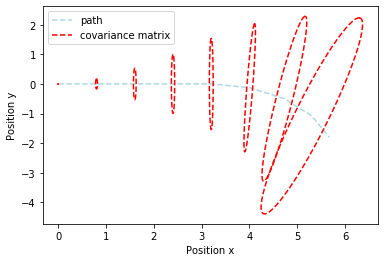

In [436]:
#only prediction
#robot path in blue and its position uncertainy is displayed in red
plt.plot([x[0][0] for x in state_pred], [x[1][0] for x in state_pred], "--r", color='lightblue', label="path")

for i in range(len(delta_sr)):
    px, py = plot_covariance_ellipse(state_pred[i], cov_pred[i]/1000)
    if i == 0:
        plt.plot(px, py, "--r", label="covariance matrix")
    plt.plot(px, py, "--r")

plt.xlabel("Position x")
plt.ylabel("Position y")
plt.legend()

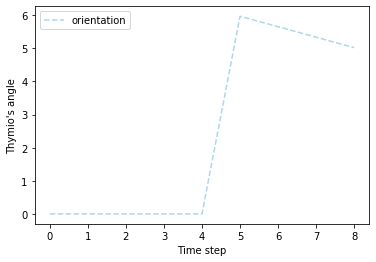

In [437]:
# evolution of the angle 
plt.plot([x[2]%(2*np.pi) for x in state_pred], "--r", color='lightblue', label="orientation")
plt.xlabel("Time step")
plt.ylabel("Thymio's angle")
plt.legend()

### Integrating the measurement 

In this part we will see the effect of integrating a measurement coming from the camera on Thymio's knowledge of his localization.

In [441]:
def kalman_filter(i, z, state_est_prev, cov_est_prev, delta_sr, delta_sl):
    """
    Estimates the current state using input sensor data and the previous state
    
    param z: array representing the measurement (x,y,theta) (coming from the vision sensor)
    param delta_sr: travelled distance for the right wheel (in meters)
    param delta_sl: travelled distance for the left wheel (in meters)
    param state_est_prev: previous state a posteriori estimation
    param cov_est_prev: previous state a posteriori covariance

    return state_est: new a posteriori state estimation
    return cov_est: new a posteriori state covariance
    """
    
    theta = state_est_prev[2,0]
    delta_s = (delta_sr + delta_sl)/2
    delta_theta = (delta_sr - delta_sl)/b
    
    Fx = jacobianF_x(theta, delta_s, delta_theta)
    Fu = jacobianF_u(theta, delta_s, delta_theta)
    
    ## Prediciton step
    # estimated mean of the state
    state_est_a_priori = state_est_prev + np.array([[delta_s*np.cos(theta + delta_theta/2)],[delta_s*np.sin(theta + delta_theta/2)],[delta_theta]])

    
    # Estimated covariance of the state
    cov_est_a_priori = np.dot(Fx, np.dot(cov_est_prev, Fx.T)) + np.dot(Fu, np.dot(R, Fu.T))
    
    if i == 2 or i == 4:
        ## Update step
        # innovation / measurement residual
        i = z - state_est_a_priori;

        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(cov_est_a_priori, np.linalg.inv(cov_est_a_priori + Q));
    
        # a posteriori estimate
        state_est = state_est_a_priori + np.dot(K,i);
        cov_est = cov_est_a_priori - np.dot(K,cov_est_a_priori);
 
    else:
        state_est = state_est_a_priori
        cov_est = cov_est_a_priori
            
    return state_est, cov_est
   

In [442]:
state_est = [np.array([[0], [0], [0]])]
cov_est = [0.01 * np.ones([3,3])]


delta_sl = [0.8, 0.8, 0.8, 0.8, 0.83, 0.83, 0.83, 0.83]
delta_sr = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

# virtual measurements 
z1 = np.array([[2.5], [0.1], [0.01]]) # true position is (2.4, 0, 0)         // i == 2
z2 = np.array([[4], [-0.14], [-0.33]])  # true position is (4, -0.12, -0.32)   // i == 4
z3 = np.array([[5.2], [-1.1], [-0.9]])  # true position is (5.3, -1.07, -0.95) // i == 6

z = [z1, z2, z3]

meas = 0
for i in tqdm(range(len(delta_sr))):

    if i == 2:
        meas = 0
        
    if i == 4:
        meas = 1
    
    #if i == 6:
        #meas = 2
    
    new_state_est, new_cov_est = kalman_filter(i, z[meas], state_est[-1], cov_est[-1], delta_sr[i], delta_sl[i])
    
    
    state_est.append(new_state_est)
    cov_est.append(new_cov_est)

100%|██████████| 8/8 [00:00<00:00, 4179.68it/s]


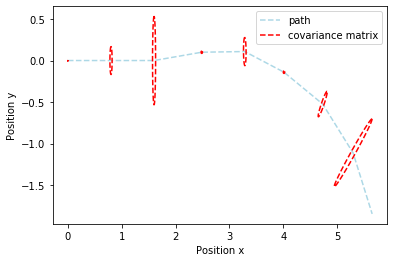

In [443]:
# prediction + 1 update
#robot path in blue and its position uncertainy is displayed in red
plt.plot([x[0][0] for x in state_est], [x[1][0] for x in state_est], "--r", color='lightblue', label="path")

for i in range(len(delta_sr)):
    px, py = plot_covariance_ellipse(state_est[i], cov_est[i]/1000)
    if i == 0:
        plt.plot(px, py, "--r", label="covariance matrix")
    plt.plot(px, py, "--r")

plt.xlabel("Position x")
plt.ylabel("Position y")
plt.legend()